# Exercise 2: Intrusion Detection for Unix Processes

Apply the negative selection algorithm to detect anomalous system call sequences.

**Datasets:** `snd-cert` and `snd-unm` (in `syscalls/`)

**Key differences from Exercise 1:**
- Sequences are variable-length (up to ~1000 chars vs fixed 10 in the language example)
- Labels are in separate `.labels` files (0 = normal, 1 = anomalous)
- Must specify `-alphabet file://<alpha_file>` since the alphabet differs from the training data

**Approach:** Pre-process variable-length sequences into fixed-length chunks of size `n`
(non-overlapping to keep runtime manageable). For each test sequence, chunk it, score each chunk
with negsel, and average the chunk scores into a composite anomaly score.

In [14]:
import subprocess
import tempfile
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import roc_curve, roc_auc_score
from google.colab import drive

In [15]:
drive.mount('/content/drive')
BASE_DIR = Path("/content/drive/MyDrive/MDSc_Radboud_University/NaturalComputing")
NEGSEL_JAR = BASE_DIR / "negsel2.jar"
SYSCALLS_DIR = BASE_DIR / "syscalls"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Data Loading & Exploration

In [16]:
def load_dataset(name: str):
    """Load a syscalls dataset (e.g. 'snd-cert' or 'snd-unm')."""
    d = SYSCALLS_DIR / name
    train_file = d / f"{name}.train"
    alpha_file = d / f"{name}.alpha"
    train_seqs = train_file.read_text().strip().split("\n")
    
    test_sets = []
    for i in [1, 2, 3]:
        test_seqs = (d / f"{name}.{i}.test").read_text().strip().split("\n")
        labels = [int(x) for x in (d / f"{name}.{i}.labels").read_text().strip().split("\n")]
        test_sets.append((test_seqs, labels))
    
    return train_seqs, alpha_file, test_sets

In [17]:
for name in ["snd-cert", "snd-unm"]:
    train, alpha, tests = load_dataset(name)
    print(f"=== {name} ===")
    print(f"  Alphabet: {alpha.read_text().strip()[:60]}")
    print(f"  Training sequences: {len(train)}")
    train_lens = [len(s) for s in train]
    print(f"  Train seq lengths: min={min(train_lens)}, max={max(train_lens)}, median={int(np.median(train_lens))}")
    for i, (seqs, labels) in enumerate(tests, 1):
        n_anom = sum(labels)
        seq_lens = [len(s) for s in seqs]
        print(f"  Test {i}: {len(seqs)} seqs ({n_anom} anomalous, {len(seqs)-n_anom} normal), "
              f"lengths min={min(seq_lens)} max={max(seq_lens)}")
    print()

=== snd-cert ===
  Alphabet: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz/-=;
  Training sequences: 811
  Train seq lengths: min=7, max=1000, median=1000
  Test 1: 100 seqs (50 anomalous, 50 normal), lengths min=7 max=1000
  Test 2: 550 seqs (50 anomalous, 500 normal), lengths min=7 max=1000
  Test 3: 1050 seqs (50 anomalous, 1000 normal), lengths min=7 max=1000

=== snd-unm ===
  Alphabet: ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz-
  Training sequences: 1030
  Train seq lengths: min=7, max=1000, median=1000
  Test 1: 100 seqs (50 anomalous, 50 normal), lengths min=7 max=1000
  Test 2: 550 seqs (50 anomalous, 500 normal), lengths min=7 max=1000
  Test 3: 1050 seqs (50 anomalous, 1000 normal), lengths min=7 max=1000



## 2. Preprocessing: Chunking

Split variable-length sequences into non-overlapping fixed-length chunks of size `n`.
Remainders shorter than `n` are discarded.

**Why non-overlapping?** Overlapping (stride=1) on ~1000-char sequences produces ~990 chunks each.
With 800+ training sequences that's ~800K self strings for negsel — way too slow.
Non-overlapping (stride=`n`) gives ~100 chunks per sequence (for `n=10`), keeping runtime under a minute.

In [18]:
def chunk_sequence(seq: str, n: int) -> list[str]:
    """Split a sequence into non-overlapping chunks of length n."""
    return [seq[i:i+n] for i in range(0, len(seq) - n + 1, n)]

In [19]:
def write_chunked_train(train_seqs: list[str], n: int) -> Path:
    """Chunk all training sequences and write unique chunks to a temp file."""
    chunks = set()
    for seq in train_seqs:
        chunks.update(chunk_sequence(seq, n))
    
    tmp = tempfile.NamedTemporaryFile(mode="w", suffix=".train", delete=False, dir=".")
    tmp.write("\n".join(chunks) + "\n")
    tmp.close()
    print(f"Wrote {len(chunks)} unique chunks (n={n}) to {tmp.name}")
    return Path(tmp.name)

## 3. Running Negative Selection & Scoring

In [20]:
def run_negsel(train_file: Path, alpha_file: Path, test_chunks: list[str],
               n: int, r: int) -> list[float]:
    """Run negsel2.jar and return the anomaly score for each test chunk."""
    cmd = [
        "java", "-jar", str(NEGSEL_JAR),
        "-alphabet", f"file://{alpha_file}",
        "-self", str(train_file),
        "-n", str(n),
        "-r", str(r),
        "-c", "-l",
    ]
    input_data = "\n".join(test_chunks) + "\n"
    result = subprocess.run(cmd, input=input_data, capture_output=True, text=True, timeout=600)
    if result.returncode != 0:
        raise RuntimeError(f"negsel2 failed: {result.stderr}")
    return [float(x) for x in result.stdout.strip().split("\n") if x.strip()]

In [21]:
def score_sequences(train_file: Path, alpha_file: Path, test_seqs: list[str],
                    n: int, r: int) -> np.ndarray:
    """Score each test sequence: chunk it, score each chunk, average per sequence."""
    all_chunks = []
    seq_indices = []
    for i, seq in enumerate(test_seqs):
        chunks = chunk_sequence(seq, n)
        if not chunks:
            continue  # sequence shorter than n, gets score 0
        all_chunks.extend(chunks)
        seq_indices.extend([i] * len(chunks))
    
    chunk_scores = run_negsel(train_file, alpha_file, all_chunks, n, r)
    
    seq_scores = np.zeros(len(test_seqs))
    seq_counts = np.zeros(len(test_seqs))
    for idx, score in zip(seq_indices, chunk_scores):
        seq_scores[idx] += score
        seq_counts[idx] += 1
    seq_scores /= np.maximum(seq_counts, 1)
    return seq_scores

## 4. ROC / AUC Analysis

In [22]:
def plot_roc(labels, scores, title=""):
    fpr, tpr, _ = roc_curve(labels, scores)
    auc = roc_auc_score(labels, scores)
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
    plt.xlabel("1 - Specificity (FPR)")
    plt.ylabel("Sensitivity (TPR)")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    return auc

## 5. Baseline Experiment (n=10, r=4)

Wrote 184 unique chunks (n=10) to /content/tmp5nw9jvkx.train

Scoring snd-cert test 1 (n=10, r=4)...


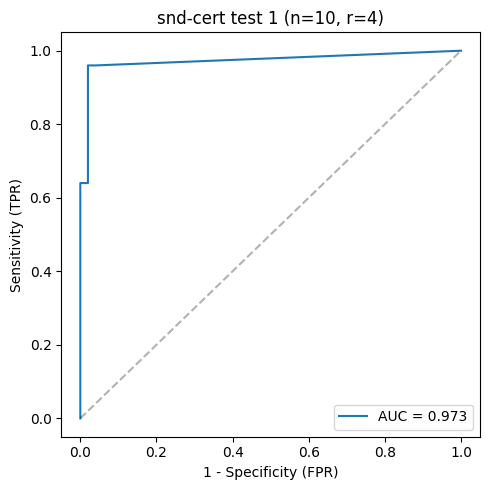

  AUC = 0.9728

Scoring snd-cert test 2 (n=10, r=4)...


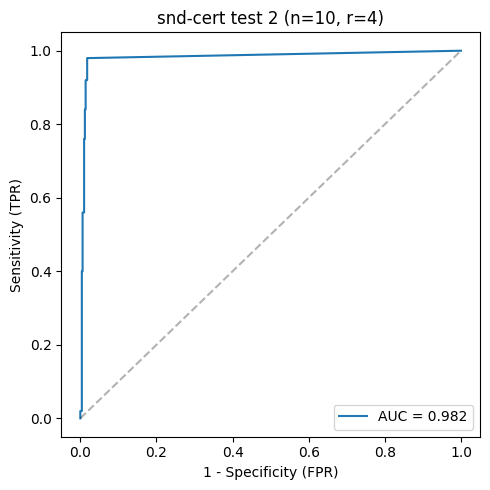

  AUC = 0.9821

Scoring snd-cert test 3 (n=10, r=4)...


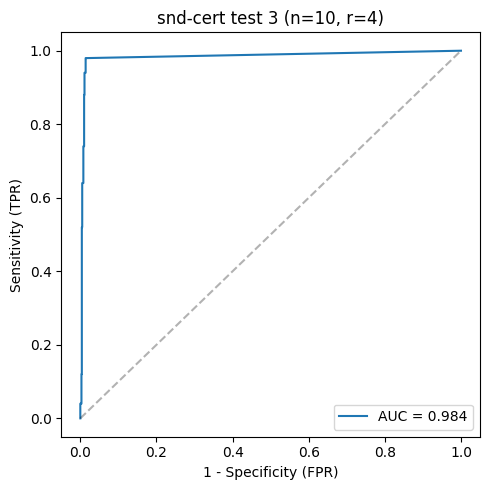

  AUC = 0.9839
Wrote 391 unique chunks (n=10) to /content/tmp4mm3x_th.train

Scoring snd-unm test 1 (n=10, r=4)...


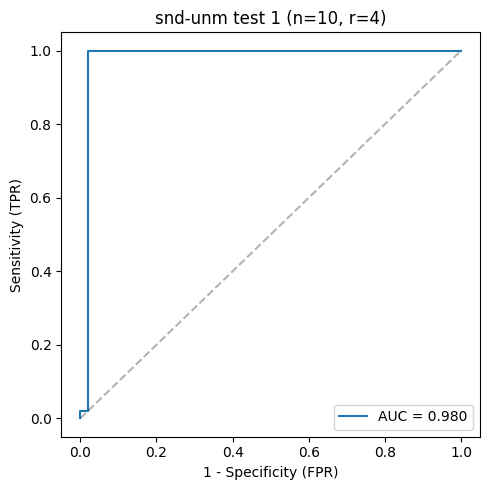

  AUC = 0.9804

Scoring snd-unm test 2 (n=10, r=4)...


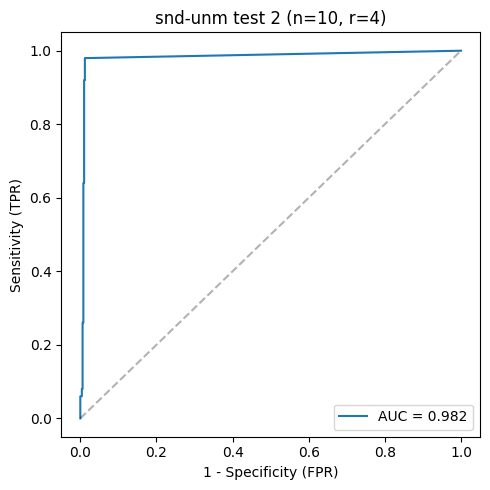

  AUC = 0.9821

Scoring snd-unm test 3 (n=10, r=4)...


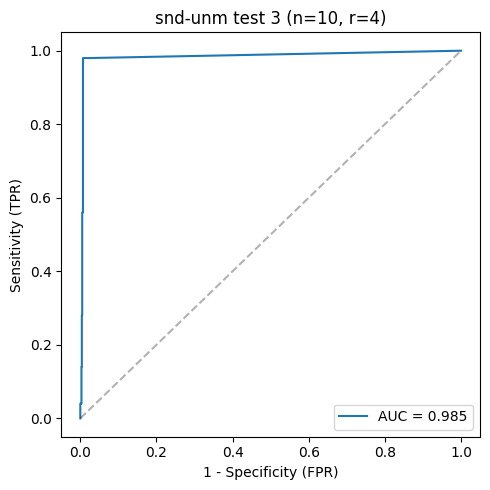

  AUC = 0.9846


In [23]:
N = 10
R = 4
results = {}

for dataset_name in ["snd-cert", "snd-unm"]:
    train_seqs, alpha_file, test_sets = load_dataset(dataset_name)
    train_file = write_chunked_train(train_seqs, N)
    
    try:
        for test_idx, (test_seqs, labels) in enumerate(test_sets, 1):
            print(f"\nScoring {dataset_name} test {test_idx} (n={N}, r={R})...")
            scores = score_sequences(train_file, alpha_file, test_seqs, N, R)
            auc = plot_roc(
                np.array(labels), scores,
                title=f"{dataset_name} test {test_idx} (n={N}, r={R})"
            )
            print(f"  AUC = {auc:.4f}")
            results[(dataset_name, test_idx)] = auc
    finally:
        Path(train_file).unlink()

## 6. Parameter Sweep

Vary `n` and `r` to find the best configuration.

In [24]:
n_values = [7, 10, 15]
r_values = [2, 3, 4, 5, 6]

# Sweep on snd-unm test 1 (smallest, fastest)
dataset_name = "snd-unm"
train_seqs, alpha_file, test_sets = load_dataset(dataset_name)
test_seqs, labels = test_sets[0]

sweep_results = {}

for n in n_values:
    train_file = write_chunked_train(train_seqs, n)
    try:
        for r in r_values:
            if r >= n:
                continue
            print(f"n={n}, r={r}...", end=" ")
            try:
                scores = score_sequences(train_file, alpha_file, test_seqs, n, r)
                auc = roc_auc_score(labels, scores)
                print(f"AUC={auc:.4f}")
                sweep_results[(n, r)] = auc
            except Exception as e:
                print(f"Error: {e}")
    finally:
        Path(train_file).unlink()

Wrote 445 unique chunks (n=7) to /content/tmpd3vpwzi1.train
n=7, r=2... AUC=0.9300
n=7, r=3... AUC=0.9700
n=7, r=4... AUC=0.9700
n=7, r=5... AUC=0.9900
n=7, r=6... AUC=0.9900
Wrote 391 unique chunks (n=10) to /content/tmpivtyif4t.train
n=10, r=2... AUC=0.9700
n=10, r=3... AUC=0.9804
n=10, r=4... AUC=0.9804
n=10, r=5... AUC=0.9804
n=10, r=6... AUC=0.9804
Wrote 374 unique chunks (n=15) to /content/tmpg9hkksif.train
n=15, r=2... Error: Input contains NaN.
n=15, r=3... Error: Input contains NaN.
n=15, r=4... Error: Input contains NaN.
n=15, r=5... AUC=0.9900
n=15, r=6... AUC=0.9900


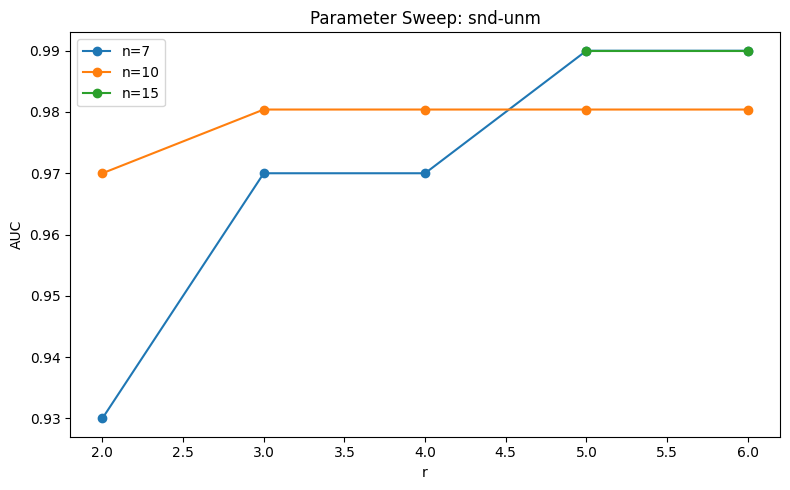

In [25]:
if sweep_results:
    fig, ax = plt.subplots(figsize=(8, 5))
    for n in n_values:
        rs = sorted([r for (nn, r) in sweep_results if nn == n])
        aucs = [sweep_results[(n, r)] for r in rs]
        if rs:
            ax.plot(rs, aucs, "o-", label=f"n={n}")
    ax.set_xlabel("r")
    ax.set_ylabel("AUC")
    ax.set_title(f"Parameter Sweep: {dataset_name}")
    ax.legend()
    plt.tight_layout()
    plt.show()

## 7. Final Evaluation with Best Parameters

In [26]:
# TODO: Set best parameters from the sweep above
BEST_N = 10
BEST_R = 4

# Re-run on all test sets with the best parameters and produce final ROC plots

## 8. Discussion

**TODO:** Answer the following in the report:

1. What preprocessing choices did you make (chunking strategy, overlap vs non-overlap) and why?
2. How did you aggregate chunk-level scores into sequence-level anomaly scores?
3. What parameters `n` and `r` worked best and why?
4. How well does the classifier perform on each dataset (`snd-cert` vs `snd-unm`)?
5. What would be the biggest challenges in implementing the negative selection algorithm yourself?